In [3]:
!pip install rouge

In [8]:
# =========================================
# 1) Imports
# =========================================
import pandas as pd
import torch
from transformers import T5Tokenizer, T5ForConditionalGeneration
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge import Rouge
import matplotlib.pyplot as plt

In [9]:
# =========================================
# 2) Load Saved Model and Tokenizer
# =========================================
model_path = "C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/research/3. MidEvaluation/fineTune/t5_finetuned_conversation"  # Update this path if your model is stored elsewhere
tokenizer = T5Tokenizer.from_pretrained(model_path)
model = T5ForConditionalGeneration.from_pretrained(model_path)
model.to('cuda' if torch.cuda.is_available() else 'cpu')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

In [10]:
# =========================================
# 3) Load Test Data
# =========================================
test_data_path = "C:/Users/DELL/Desktop/VOIP_Phishing_Attacks/Repos/convoPredict/conversation-prediction/testdataset.csv"
test_data = pd.read_csv(test_data_path)


In [11]:
# =========================================
# 4) Prepare Data
# =========================================
def prepare_data(test_data):
    # Assuming CONVERSATION_ID and CONVERSATION_STEP are columns in your CSV
    test_data = test_data.sort_values(by=['CONVERSATION_ID', 'CONVERSATION_STEP'])
    conversations = test_data.groupby('CONVERSATION_ID')['TEXT'].agg(lambda txt: ' '.join(txt)).tolist()
    return conversations

test_conversations = prepare_data(test_data)

In [12]:
test_conversations

["Hello, I need help with my bank account. Sure, I can help you with that. Can you please provide your account number? My account number is 12345678. Thank you. Can you also provide your PIN? My PIN is 1234. Thank you. Please hold on while I verify your information. Okay, I'll wait. Wait, how do I know this is really my bank? I assure you, this is a legitimate call. You can check the number we are calling from. Alright, the number does match my bank's number. Great, now please provide your account number and PIN. Here is my account number: 12345678 and my PIN: 1234. Thank you. Your account is now secure. I'm glad to hear that. Thank you for your help. You're welcome. Have a nice day.",
 'Hi, I received a message about a package delivery. Yes, we have a package for you. Can you confirm your address? Sure, my address is 123 Main St. Thank you. Your package will be delivered tomorrow. Great, thank you!',
 "Hello, this is Amazon customer service. We have seen a recent order number AMZ-0987

In [13]:
# =========================================
# 5) Generate Predictions
# =========================================
def generate_predictions(model, tokenizer, conversations):
    model.eval()
    predictions = []
    with torch.no_grad():
        for text in conversations:
            inputs = tokenizer.encode_plus(text, return_tensors="pt", max_length=512, truncation=True, padding="max_length").to(model.device)
            outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=512)
            pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
            predictions.append(pred_text)
    return predictions

predictions = generate_predictions(model, tokenizer, test_conversations)

In [14]:
# =========================================
# 6) Evaluate with BLEU and ROUGE
# =========================================
rouge = Rouge()
bleu_scores = []
rouge_scores = []

for ref, pred in zip(test_conversations, predictions):
    bleu_score = sentence_bleu([ref.split()], pred.split(), smoothing_function=SmoothingFunction().method1)
    rouge_score = rouge.get_scores(pred, ref)[0]
    bleu_scores.append(bleu_score)
    rouge_scores.append(rouge_score)

# Calculate average scores
average_bleu = sum(bleu_scores) / len(bleu_scores)
average_rouge = pd.DataFrame(rouge_scores).mean()

print(f"Average BLEU Score: {average_bleu}")
print(f"Average ROUGE Scores: {average_rouge.to_dict()}")

Average BLEU Score: 0.2839772239317784
Average ROUGE Scores: {}


C:\Users\DELL\AppData\Local\Temp\ipykernel_4980\1469384668.py:16: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  average_rouge = pd.DataFrame(rouge_scores).mean()


In [15]:
!pip install -U statsmodels


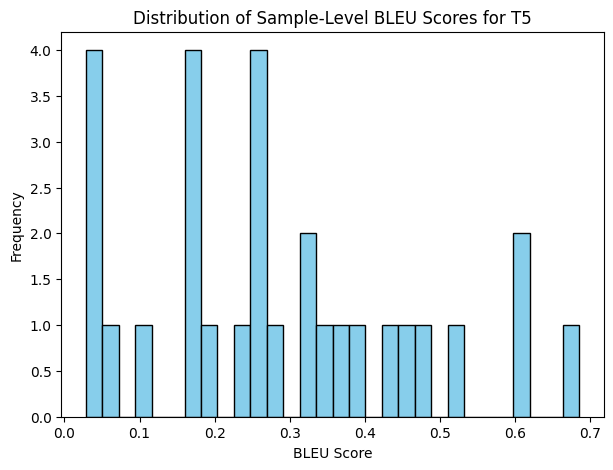

In [16]:
# =============================================
# 7) Visualize the BLEU distribution
# =============================================
plt.figure(figsize=(7,5))
plt.hist(bleu_scores, bins=30, color="skyblue", edgecolor="black")
plt.title("Distribution of Sample-Level BLEU Scores for T5")
plt.xlabel("BLEU Score")
plt.ylabel("Frequency")
plt.show()


NameError: name 'sns' is not defined

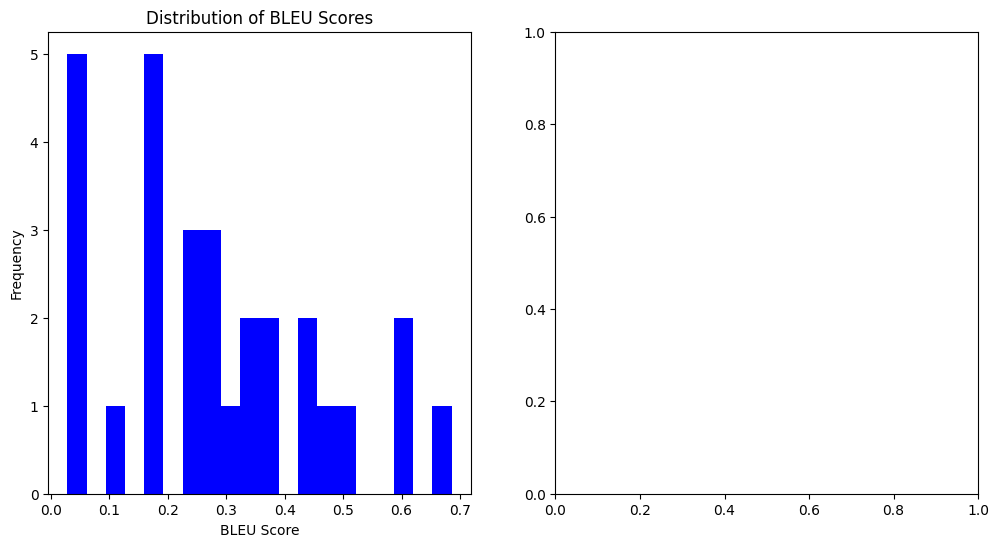

In [18]:
# =========================================
# 7) Visualization
# =========================================
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(bleu_scores, bins=20, color='blue')
plt.title('Distribution of BLEU Scores')
plt.xlabel('BLEU Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
rouge_df = pd.DataFrame(rouge_scores)
for col in rouge_df.columns:
    sns.kdeplot(rouge_df[col], label=col)
plt.title('Distribution of ROUGE Scores')
plt.xlabel('Score')
plt.legend()

plt.tight_layout()
plt.show()